# Assigment 2 

In this assigment we will work on a regression algorithm for predicting the stock price on a specific date.

https://www.kdnuggets.com/2023/08/times-series-analysis-arima-models-python.html

# Imports

In [889]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Read data from csv
### We read the file using pandas to 

In [890]:
df = pd.read_csv("../data/TSLA-2018.csv")  # Read from file, (comma is the default)
df.head()  # Get an overview of the dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,20.799999,21.474001,20.733334,21.368668,21.368668,65283000
1,2018-01-03,21.400000,21.683332,21.036667,21.150000,21.150000,67822500
2,2018-01-04,20.858000,21.236668,20.378668,20.974667,20.974667,149194500
3,2018-01-05,21.108000,21.149332,20.799999,21.105333,21.105333,68868000
4,2018-01-08,21.066668,22.468000,21.033333,22.427334,22.427334,147891000


In [891]:
# Check if we have any null values in our dataset
print(f"Any null values? {df.isnull().values.any()}")
df.info()  # Check the types for values

Any null values? False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1466 entries, 0 to 1465
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1466 non-null   object 
 1   Open       1466 non-null   float64
 2   High       1466 non-null   float64
 3   Low        1466 non-null   float64
 4   Close      1466 non-null   float64
 5   Adj Close  1466 non-null   float64
 6   Volume     1466 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 80.3+ KB


We can see that the date column is not recognised, we need to convert it to the right type

## Clean and convert the data

In [892]:
df['Date'] = pd.to_datetime(df['Date'])  # Convert from string to datetime
df.head()  # Get an overview of the dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,20.799999,21.474001,20.733334,21.368668,21.368668,65283000
1,2018-01-03,21.400000,21.683332,21.036667,21.150000,21.150000,67822500
2,2018-01-04,20.858000,21.236668,20.378668,20.974667,20.974667,149194500
3,2018-01-05,21.108000,21.149332,20.799999,21.105333,21.105333,68868000
4,2018-01-08,21.066668,22.468000,21.033333,22.427334,22.427334,147891000


## See correlations if any

<Axes: >

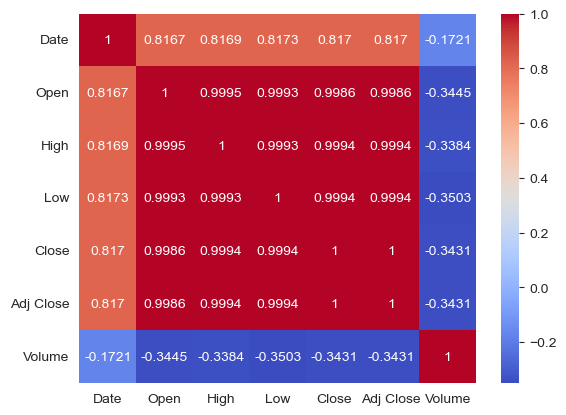

In [893]:
sns.heatmap(df.corr(), annot=True, fmt=".4g", cmap="coolwarm")

We can see that Close and Adj Close is the same ^

In [894]:
# Drop the 'Adj Close' column
df = df.drop(['Adj Close'], axis='columns')

### Visualize the data

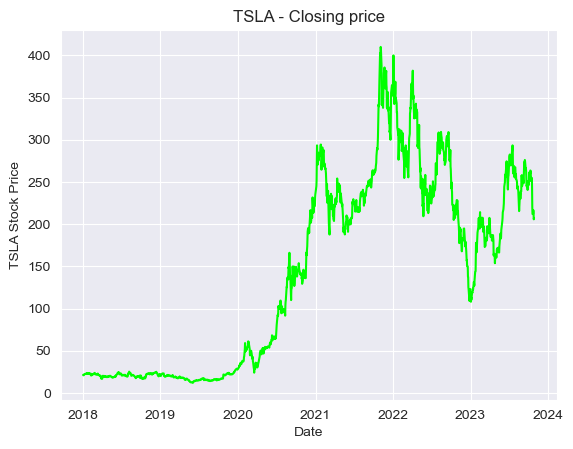

In [895]:
plt.plot(df['Date'], df['Close'], color='lime')
plt.title("TSLA - Closing price")
plt.xlabel('Date')
plt.ylabel('TSLA Stock Price')
plt.show()

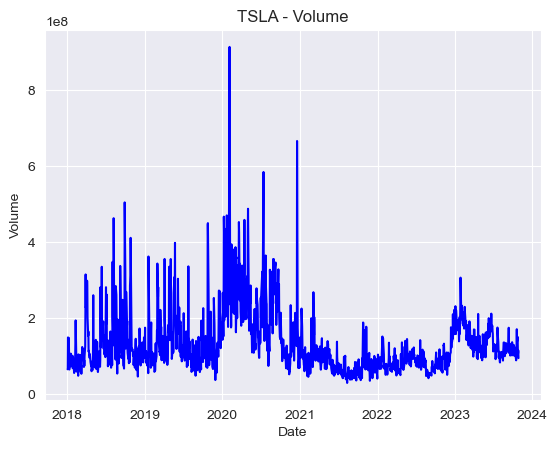

In [896]:
plt.plot(df['Date'], df['Volume'], color='blue')
plt.title("TSLA - Volume")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

### Check distribution using boxplots

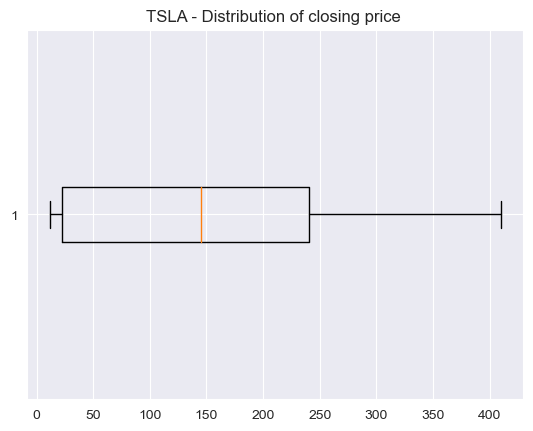

In [897]:
plt.boxplot(df['Close'], vert=False)
plt.title("TSLA - Distribution of closing price ")
plt.show()

We can see that our distribution okay, we don't need to remove any outliers.

### Train the models (Polynomial Regression and ARIMA)


#### Splitting the training and testing set for Polynomial Regression

In [898]:
X = pd.DataFrame(df['Date'])  #Date
y = pd.DataFrame(df['Close'])  #Close

# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

#### Training with Polynomial Regression

In [899]:
test_degrees = 5  # Try different degrees of polynomial features
mse_degrees = []  # Create a list to store the MSE for each degree

# Loop through the degrees and fit the model, this is to find the best degree
for test_degrees in range(test_degrees):
    # Create polynomial features for the training and testing set
    polynomial_features = PolynomialFeatures(degree=test_degrees)  # Create polynomial features
    x_poly = polynomial_features.fit_transform(X_train)  # Fit and transform the training set
    x_poly_test = polynomial_features.fit_transform(X_test)  # Fit and transform the testing set

    # Train the model
    model = LinearRegression()  # Create a linear regression object
    model.fit(x_poly, y_train)  # Fit the model using the training set
    y_poly_pred = model.predict(x_poly_test)  # Predict the values for the testing set

    # Calculate the MSE on the testing set
    mse = metrics.mean_squared_error(y_test, y_poly_pred)
    mse_degrees.append((mse, test_degrees))  # Add the MSE and degree to the list 
    print(f"MSE = {mse} for degree = {test_degrees}")

# Sort the list of MSE to find the best degree
mse_degrees.sort()

# Get the best degree from the list
best_degree = mse_degrees[0][1]

print(f"Best degree {best_degree}")

# Train the model with the best degree we found again

# Create polynomial features for the training and testing set
polynomial_features = PolynomialFeatures(degree=best_degree)  # Create polynomial features
x_poly = polynomial_features.fit_transform(X_train)  # Fit and transform the training set
x_poly_test = polynomial_features.fit_transform(X_test)  # Fit and transform the testing set

# Train the model
model = LinearRegression()  # Create a linear regression object
model.fit(x_poly, y_train)  # Fit the model using the training set
y_poly_pred = model.predict(x_poly_test)  # Predict the values for the testing set

MSE = 13549.966474953068 for degree = 0
MSE = 4772.636361630205 for degree = 1
MSE = 4822.742766966362 for degree = 2
MSE = 4879.038926666749 for degree = 3
MSE = 4941.331495777418 for degree = 4
Best degree 1


### Visualize the data

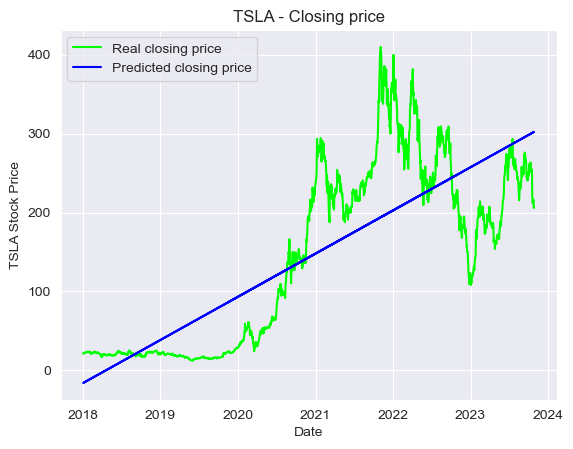

MSE = 4772.636361630205 for degree = 1


In [900]:
plt.plot(X, y, label='Real closing price', color='lime')
plt.plot(X_test, y_poly_pred, label='Predicted closing price', color='blue')
plt.title("TSLA - Closing price")
plt.xlabel('Date')
plt.ylabel('TSLA Stock Price')
plt.legend()
plt.show()

# Calculate the MSE on the testing set
mse = metrics.mean_squared_error(y_test, y_poly_pred)
print(f"MSE = {mse} for degree = {best_degree}")

We can see that the MSE is quite high, this is because we are using a polynomial regression model on a time series dataset. We can see that the most fitting polynomial model is the model with only one degree (a polynomial model with 1 degree means its linear and has no degrees. It would be better to use a time series model such as ARIMA or SARIMAX (Dhaduk, 2021). Let's try to use ARIMA instead.

#### Splitting the training and testing set for ARIMA

In [901]:
# Inspiration taken from https://www.kdnuggets.com/2023/08/times-series-analysis-arima-models-python.html

# Set the date to be the index 
df = df.set_index('Date')

# Test size in percentage
test_size = 0.33

train_size = int(len(df) * (1 - test_size))  # Calculate how large portion that should be used for testing. 

# Take training data from the start of the dataframe, then use the rest for testing data
train_data, test_data = df[0:train_size], df[train_size:]
train_data, test_data = train_data['Close'], test_data['Close']  # Train and test from the Close column 

#### Training of the model

In [902]:
# Initial data setup
training_history = [x for x in train_data]  # Create a copy of the training data
predictions = []  # Store model predictions
y = test_data

arima_order = (1, 1, 0)  # ARIMA model order
model = None  # This is defined here, so we can use the same ARIMA model after training.

# Rolling forecasts
for i in range(len(y)):
    # Initialize the model with the training history and the arima order set
    model = ARIMA(training_history, order=arima_order)

    #Train the ARIMA model
    model_fit = model.fit()

    # Make a one-step-ahead forecast
    forecasted_value = model_fit.forecast()[0]

    # Append the forecasted value to the predictions list
    predictions.append(forecasted_value)

    # Update the training history with the observed value
    training_history.append(y[i])

### Show the results

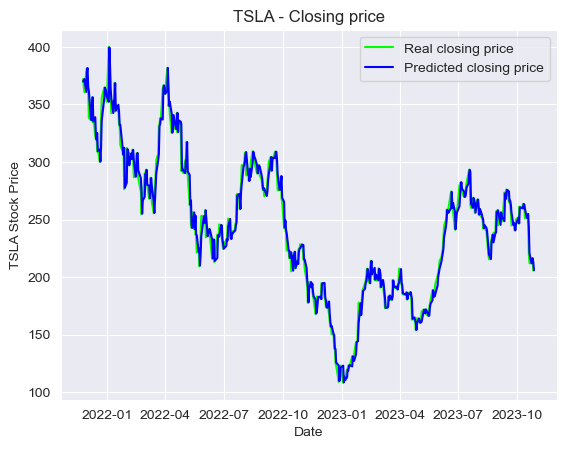

Mean squared error: 95.83690184172487


In [903]:
plt.plot(test_data.index, y, label="Real closing price", color="lime")
plt.plot(test_data.index, predictions, label='Predicted closing price', color='blue')
plt.title("TSLA - Closing price")
plt.xlabel('Date')
plt.ylabel('TSLA Stock Price')
plt.legend()
plt.show()

mse = mean_squared_error(y, predictions)
print(f"Mean squared error: {mse}")


We can see that this Mean Squared error is much better than using Polynomial regression.

### Save the model

In [904]:
filename = "TSLA-ARIMA-2018.cc"
pickle.dump(model, open(filename, 'wb'))